In [71]:
import numpy as np
import pandas as pd
import pickle as pkl
import lmfit as lm
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook

from configs import (
    pklfit_temp_hall,
    pklfit_temp_hall_nmr,
    pklfit_temp_nmr,
    pklinfo,
    pklproc,
    pklproc_hyst,
    pklproc_ramp,
    probe
)
from model_funcs import mod_lin, mod_lin_alt, ndeg_poly
from plotting import config_plots, datetime_plt
config_plots()
from factory_funcs import get_NMR_B_at_T0_func, get_Hall_B_at_T0_func

In [86]:
# load info df
df_info = pd.read_pickle(pklinfo)
proc_ramp = pd.read_pickle(pklproc_ramp)
proc_hyst = pd.read_pickle(pklproc_hyst)
results_nmr = pkl.load(open(pklfit_temp_nmr, 'rb'))
results_hall = pkl.load(open(pklfit_temp_hall, 'rb'))
results_hall_nmr = pkl.load(open(pklfit_temp_hall_nmr, 'rb'))

In [87]:
results_nmr[0]

In [73]:
proc_ramp

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,C90000000D53983A_Cal_Theta,C90000000D53983A_Cal_Phi,C50000000D5E473A_Cal_Bmag,C50000000D5E473A_Raw_Bmag,C50000000D5E473A_Cal_Theta,C50000000D5E473A_Cal_Phi,6A0000000D61333A_Cal_Bmag,6A0000000D61333A_Raw_Bmag,6A0000000D61333A_Cal_Theta,6A0000000D61333A_Cal_Phi
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-03-01 13:21:43,3/1/2021 1:21:43 PM,0.000849,0.000395,7.688446,7.691459,6.898076,7.368879,7.800656,6.925324,12.731566,...,1.161876,-2.253625,0.000159,357.913397,2.332208,0.335641,0.000858,7.164410e+03,1.625786,-3.124481
2021-03-01 13:22:43,3/1/2021 1:22:43 PM,0.001091,-0.001118,7.643955,7.702847,6.885967,7.356124,7.805821,6.908267,12.722416,...,1.141849,-2.348143,0.000154,373.482262,2.391755,0.327818,0.000908,7.311638e+03,1.627186,3.125966
2021-03-01 13:23:43,3/1/2021 1:23:43 PM,0.001039,-0.000333,7.624253,7.710751,6.905254,7.374886,7.772696,6.924972,12.710895,...,1.235545,-1.874310,0.000115,326.566992,2.352665,0.443952,0.000904,7.283934e+03,1.638416,-3.126097
2021-03-01 13:24:43,3/1/2021 1:24:43 PM,0.000718,0.000996,7.651546,7.712375,6.935202,7.386232,7.751643,6.941383,12.705977,...,0.928488,-2.412174,0.000123,317.712134,2.326194,0.459363,0.000911,7.310320e+03,1.628255,-3.138970
2021-03-01 13:25:43,3/1/2021 1:25:43 PM,0.001004,-0.000206,7.638594,7.720768,6.922057,7.367510,7.786451,6.953355,12.700392,...,1.465051,-2.176981,0.000129,307.070025,2.324363,0.597280,0.000924,7.348007e+03,1.636281,3.136235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-11 17:46:47,3/11/2021 5:46:47 PM,281.677420,36.814150,51.974365,51.455513,16.494814,22.697769,23.309382,31.614250,25.736761,...,0.934414,0.245358,0.020067,54212.413136,0.435055,-1.808301,1.306971,3.617085e+06,1.533332,-0.029959
2021-03-11 17:47:47,3/11/2021 5:47:47 PM,281.677477,36.814183,51.953983,51.460171,16.498129,22.703094,23.390150,31.622131,25.739260,...,0.934744,0.247347,0.020051,54170.280450,0.435003,-1.808518,1.306981,3.617149e+06,1.533339,-0.029953
2021-03-11 17:48:47,3/11/2021 5:48:47 PM,281.677647,36.814433,51.900555,51.444550,16.515627,22.720036,23.383900,31.625975,25.749882,...,0.934542,0.244217,0.020051,54170.307079,0.436543,-1.809039,1.306977,3.617184e+06,1.533342,-0.029934


In [88]:
ramps = df_info[df_info.ramp].index
df_ramp = df[np.isin(df.run_num, ramps)]

In [89]:
ramps

Int64Index([3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18], dtype='int64')

In [84]:
nmrs = df_info[df_info.NMR].index
proc_ramp_nmr = df[np.isin(df.run_num, ramps)]

In [74]:
len(df_ramp)

6816

In [70]:
df_ramp.run_num.unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [58]:
df_info

,t0,tf,ramp,hyst,adc,chiller,NMR,B_NMR,I,hours_data,num_meas
0,2021-02-24 09:57:00,2021-02-25 10:35:45,False,True,"750,000",True,True,1.207960,240.069467,24.645833,1479
1,2021-02-25 10:36:15,2021-02-26 11:47:45,False,True,"700,000",True,True,1.158911,224.065923,25.191667,1512
2,2021-02-26 11:53:00,2021-03-01 09:12:45,False,True,"750,000",True,True,1.208438,240.069009,69.329167,4161
3,2021-03-01 09:18:30,2021-03-01 16:47:45,True,False,0,True,False,0.000000,0.000850,7.487500,450
4,2021-03-01 16:51:30,2021-03-02 09:11:45,True,False,"100,000",True,False,0.000000,32.011006,16.337500,981
5,2021-03-02 09:16:30,2021-03-02 16:53:45,True,False,"200,000",True,False,0.000000,64.021711,7.620833,458
6,2021-03-02 16:57:30,2021-03-03 09:12:45,True,False,"300,000",True,False,0.000000,96.028746,16.254167,976
7,2021-03-03 09:16:30,2021-03-03 17:11:45,True,False,"400,000",True,True,0.732467,128.038948,7.920833,476
8,2021-03-03 17:15:30,2021-03-04 09:10:45,True,False,"450,000",True,True,0.821564,144.044132,15.920833,956
9,2021-03-04 09:14:45,2021-03-04 16:49:45,True,True,"500,000",True,True,0.906698,160.047885,7.583333,456


In [45]:
df = pd.read_pickle(pklproc)

In [47]:
df.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'Coil 1 (new)',
       'Coil 2 (old)', 'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2',
       'LCW out Coil 2', 'Yoke',
       ...
       'C90000000D53983A_Cal_Theta', 'C90000000D53983A_Cal_Phi',
       'C50000000D5E473A_Cal_Bmag', 'C50000000D5E473A_Raw_Bmag',
       'C50000000D5E473A_Cal_Theta', 'C50000000D5E473A_Cal_Phi',
       '6A0000000D61333A_Cal_Bmag', '6A0000000D61333A_Raw_Bmag',
       '6A0000000D61333A_Cal_Theta', '6A0000000D61333A_Cal_Phi'],
      dtype='object', length=102)

In [48]:
from preprocess_data import get_probe_IDs

In [49]:
probes = get_probe_IDs(df)

In [50]:
probes

['DF0000000D5E803A',
 'C90000000D53983A',
 'C50000000D5E473A',
 '6A0000000D61333A']

In [53]:
df_ = df.query('run_num == 18').copy()

In [54]:
df_

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,C90000000D53983A_Cal_Theta,C90000000D53983A_Cal_Phi,C50000000D5E473A_Cal_Bmag,C50000000D5E473A_Raw_Bmag,C50000000D5E473A_Cal_Theta,C50000000D5E473A_Cal_Phi,6A0000000D61333A_Cal_Bmag,6A0000000D61333A_Raw_Bmag,6A0000000D61333A_Cal_Theta,6A0000000D61333A_Cal_Phi
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-03-11 15:57:47,3/11/2021 3:57:47 PM,281.677590,36.793150,51.704414,51.306629,16.363602,22.565411,23.183760,31.495747,25.627001,...,0.941961,0.236090,0.020069,54220.289726,0.437432,-1.812049,1.307023,3.617329e+06,1.533334,-0.029954
2021-03-11 15:58:46,3/11/2021 3:58:46 PM,281.677420,36.793517,51.744041,51.323757,16.365896,22.558846,23.269617,31.486939,25.623087,...,0.926689,0.240208,0.020043,54150.089021,0.435635,-1.810582,1.306957,3.617103e+06,1.533320,-0.029958
2021-03-11 15:59:47,3/11/2021 3:59:47 PM,281.677477,36.793867,51.739975,51.308433,16.368290,22.576220,23.420244,31.456947,25.616379,...,0.926878,0.222470,0.020051,54170.118534,0.436348,-1.807469,1.307008,3.617255e+06,1.533338,-0.029951
2021-03-11 16:00:47,3/11/2021 4:00:47 PM,281.677420,36.794017,51.791916,51.301338,16.358423,22.555132,23.342188,31.458742,25.628515,...,0.930809,0.240929,0.020065,54210.509249,0.436528,-1.808431,1.307011,3.617294e+06,1.533319,-0.029957
2021-03-11 16:01:47,3/11/2021 4:01:47 PM,281.677420,36.794200,51.852283,51.369842,16.347948,22.559830,23.251493,31.500338,25.633768,...,0.927699,0.242826,0.020069,54219.179826,0.434284,-1.810165,1.306984,3.617100e+06,1.533345,-0.029958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-11 17:46:47,3/11/2021 5:46:47 PM,281.677420,36.814150,51.974365,51.455513,16.494814,22.697769,23.309382,31.614250,25.736761,...,0.934414,0.245358,0.020067,54212.413136,0.435055,-1.808301,1.306971,3.617085e+06,1.533332,-0.029959
2021-03-11 17:47:47,3/11/2021 5:47:47 PM,281.677477,36.814183,51.953983,51.460171,16.498129,22.703094,23.390150,31.622131,25.739260,...,0.934744,0.247347,0.020051,54170.280450,0.435003,-1.808518,1.306981,3.617149e+06,1.533339,-0.029953
2021-03-11 17:48:47,3/11/2021 5:48:47 PM,281.677647,36.814433,51.900555,51.444550,16.515627,22.720036,23.383900,31.625975,25.749882,...,0.934542,0.244217,0.020051,54170.307079,0.436543,-1.809039,1.306977,3.617184e+06,1.533342,-0.029934


In [57]:
for p in probes:
    bme = df_[f'{p}_Cal_Bmag'].mean()
    bma = df_[f'{p}_Cal_Bmag'].max()
    print(f'probe: {p}, mean(|B|): {bme} T, max(|B|): {bma} T')

probe: DF0000000D5E803A, mean(|B|): 0.7244259314139324 T, max(|B|): 0.724479045768219 T
probe: C90000000D53983A, mean(|B|): 0.0029400374836729584 T, max(|B|): 0.002986819921755244 T
probe: C50000000D5E473A, mean(|B|): 0.02005515185619512 T, max(|B|): 0.020102613429642327 T
probe: 6A0000000D61333A, mean(|B|): 1.3069901889016722 T, max(|B|): 1.3070429780556747 T


In [5]:
# polynomial fitting

In [33]:
#params = {'C_0':1, 'C_1':-2, 'C_2':2, 'C_3':100, 'C_4': -0.21}
params = {'C_0':1, 'C_1':-2, 'C_2':2, 'C_4': -0.21}
xs = np.linspace(0, 5, 2000)

In [36]:
max_degs = np.max([int(k[2:]) for k in params.keys()])

coeffs = np.zeros(max_degs+1)

for k, v in sorted(params.items()):
    coeffs[int(k[2:])] = v
coeffs = coeffs[::-1]
p = np.poly1d(coeffs)
return p(x)

In [42]:
coeffs

array([-0.21,  0.  ,  2.  , -2.  ,  1.  ])

In [44]:
%timeit ys = ndeg_poly(xs, **params)

41.4 µs ± 78 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [43]:
#p = np.poly1d([-0.21, 100, 2, -2, 1])
#p = np.poly1d(list(params.values())[::-1])
p = np.poly1d(coeffs)

In [45]:
%timeit ys = p(xs)

16.7 µs ± 84.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [46]:
ys = ndeg_poly(xs, **params)
y2s = p(xs)

In [50]:
np.allclose(ys, y2s)

True

<IPython.core.display.Javascript object>


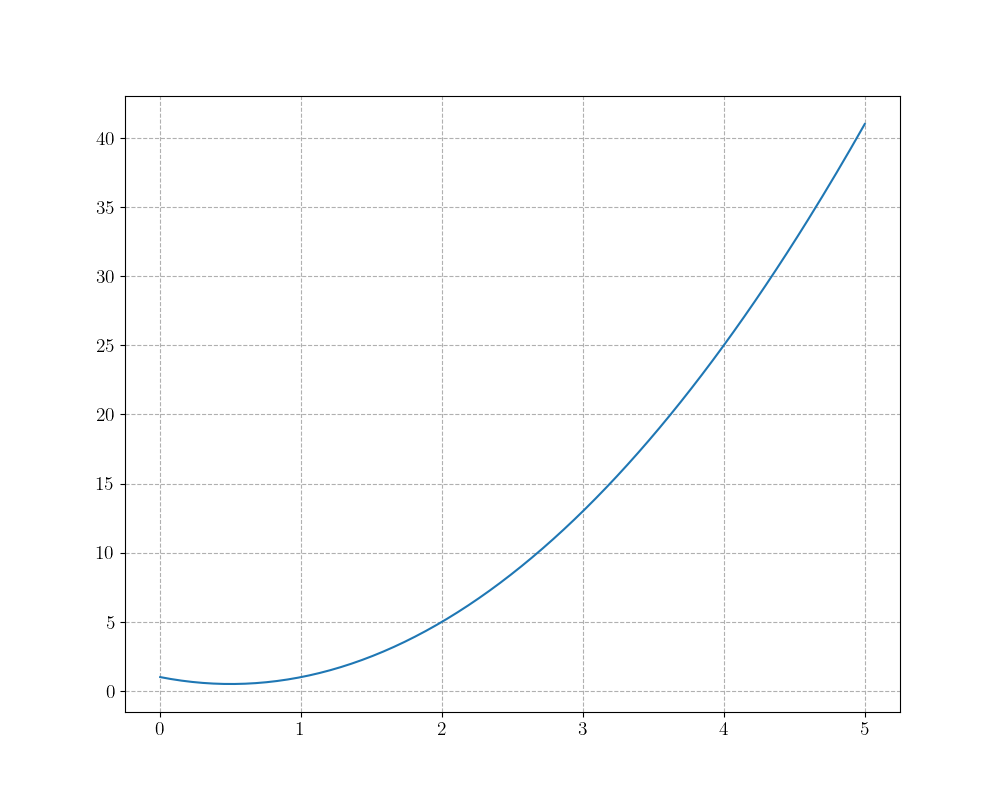

In [12]:
#params = {'C_0':10, 'C_2':3, 'C_3':-0.5}
params = {'C_0':1, 'C_1':-2, 'C_2':2}
xs = np.linspace(0, 5, 200)
ys = ndeg_poly(xs, **params)

fig, ax = plt.subplots()
ax.plot(xs, ys)

In [3]:
len(results_hall_nmr[0].params), len(results_hall_nmr[3].params)

(3, 2)

In [4]:
results_hall[6]

In [31]:
for key, val in sorted(results_hall.items()):
    print(f'run {key}: {val.params["B"]}')

run 0: <Parameter 'B', value=-7.204317289152536e-05 +/- 4.67e-06, bounds=[-inf:inf]>
run 1: <Parameter 'B', value=-0.000143592934465818 +/- 1.24e-05, bounds=[-inf:inf]>
run 2: <Parameter 'B', value=-0.00012831268343408634 +/- 7.06e-06, bounds=[-inf:inf]>
run 3: <Parameter 'B', value=-7.599424453182596e-06 +/- 6.57e-06, bounds=[-inf:inf]>
run 4: <Parameter 'B', value=-9.928510574945364e-06 +/- 1.54e-05, bounds=[-inf:inf]>
run 5: <Parameter 'B', value=-1.0362295692114762e-05 +/- 0.000116, bounds=[-inf:inf]>
run 6: <Parameter 'B', value=2.7065103822717512e-05 +/- 2.65e-05, bounds=[-inf:inf]>
run 7: <Parameter 'B', value=3.0999427126469914e-07 +/- 5.62e-05, bounds=[-inf:inf]>
run 8: <Parameter 'B', value=-1.2997503204482258e-05 +/- 2.53e-05, bounds=[-inf:inf]>
run 9: <Parameter 'B', value=1.7742075515168182e-05 +/- 7.45e-05, bounds=[-inf:inf]>
run 10: <Parameter 'B', value=-2.0893454166534182e-05 +/- 2.09e-05, bounds=[-inf:inf]>
run 11: <Parameter 'B', value=-0.00013444854904922678 +/- 9.8

In [32]:
# extra dfs
df = pd.read_pickle(pklproc)

In [33]:
df_ = df.query('run_num == 10')

In [34]:
params = lm.Parameters()
params.add('A', value=0, vary=True)

In [35]:
params['A'].vary = False

In [36]:
params['A']

<Parameter 'A', value=0 (fixed), bounds=[-inf:inf]>

<IPython.core.display.Javascript object>


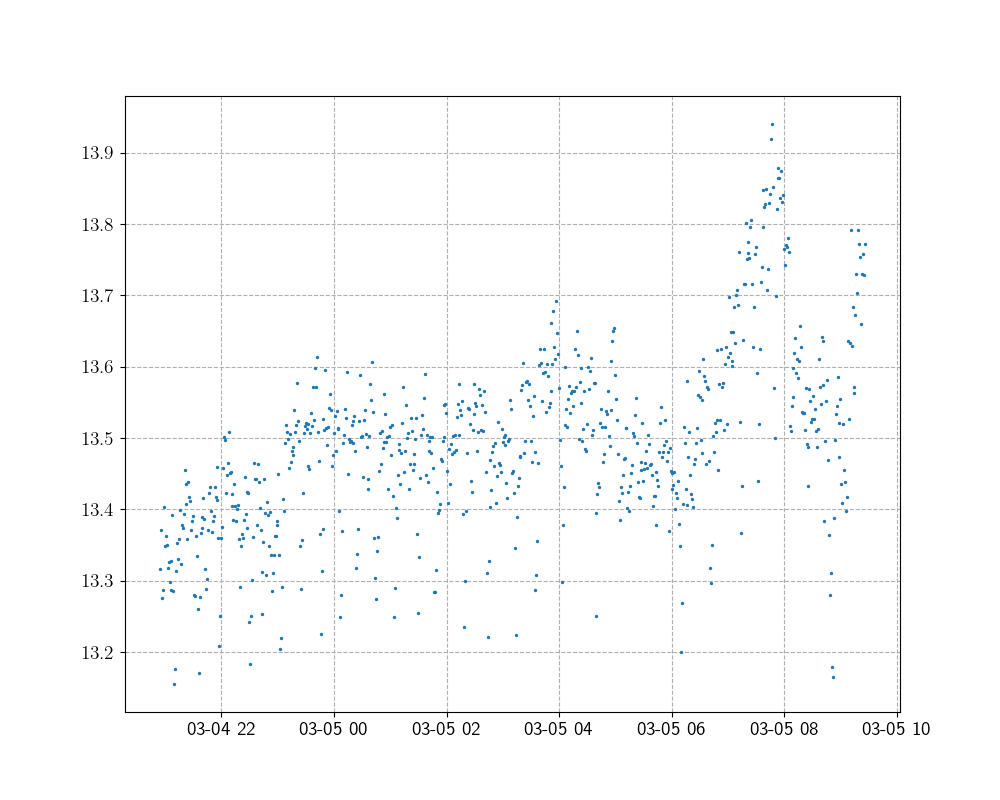

In [37]:
y = 'LCW in barrel'
fig, ax = plt.subplots()

ax.scatter(df_.index, df_[y], s=2)

In [38]:
6e-4 * 8e-3

4.8e-06

In [39]:
def lin_plus_unc(x, result):
    y0 = mod_lin(x, **result.params)
    cov = result.covar
    yerr = (x**2 * cov[1,1] + cov[0,0] + 2 * x * cov[0,1])**(1/2)
    return y0, yerr

def lin_plus_unc_old(x, result):
    y0 = mod_lin(x, **result.params)
    p_m = {'A':result.params['A'].value-result.params['A'].stderr, 'B':result.params['B']-result.params['B'].stderr}
    p_p = {'A':result.params['A'].value+result.params['A'].stderr, 'B':result.params['B']+result.params['B'].stderr}
    y_m = mod_lin(x, **p_m)
    y_p = mod_lin(x, **p_p)
    return y0, y_m-y0, y_p-y0

In [40]:
T0 = 15
for i,result in results_nmr.items():
    #if (3 <= i <= 18):
    if (7 <= i <= 18):
        print(lin_plus_unc(T0, result), end='')
        print(lin_plus_unc_old(T0, result))

(0.7339904181558112, 3.744912817890966e-06)(0.7339904181558112, -5.285607802196779e-05, 5.285607802207881e-05)
(0.8224100114095682, 1.3034996223042227e-06)(0.8224100114095682, -2.402031306791841e-05, 2.402031306791841e-05)
(0.9066650569424834, 2.928048576102843e-06)(0.9066650569424834, -7.160146201468098e-05, 7.1601462014792e-05)
(0.9839258161145357, 4.6990438260968056e-07)(0.9839258161145357, -2.046419311985126e-05, 2.0464193119962282e-05)
(1.0513718723676746, 1.0100941690920784e-06)(1.0513718723676746, -9.77419532290913e-05, 9.774195322886925e-05)
(1.0504595525603153, 6.09440293307569e-07)(1.0504595525603153, -7.19584278541241e-06, 7.19584278541241e-06)
(1.1098342378036756, 1.34311190965652e-06)(1.1098342378036756, -1.1050078729368806e-05, 1.1050078729368806e-05)
(1.161996365249929, 5.490585240320771e-06)(1.161996365249929, -3.798135678589887e-05, 3.798135678589887e-05)
(1.2092292499686752, 2.0106204302277266e-06)(1.2092292499686752, -1.1752563159550533e-05, 1.1752563159328488e-05)
(

In [41]:
T0 = 20
for i,result in results_nmr.items():
    #if (3 <= i <= 18):
    if (7 <= i <= 18):
        print(lin_plus_unc(T0, result), end='')
        print(lin_plus_unc_old(T0, result))

(0.733947570541879, 1.3177850038273348e-05)(0.733947570541879, -6.228945775521577e-05, 6.228945775521577e-05)
(0.822366560596935, 5.5236282276324625e-06)(0.822366560596935, -2.8240849378469157e-05, 2.824084937858018e-05)
(0.906536122239806, 1.5348820686796962e-05)(0.906536122239806, -8.402289859743561e-05, 8.402289859743561e-05)
(0.9837238968885857, 3.957424290491439e-06)(0.9837238968885857, -2.395296210444542e-05, 2.395296210444542e-05)
(1.0510976150963918, 1.74635120740196e-05)(1.0510976150963918, -0.00011419982382498972, 0.00011419982382521177)
(1.0501430623026513, 4.942105313695282e-07)(1.0501430623026513, -8.293927011848723e-06, 8.293927011848723e-06)
(1.1094406629811409, 2.7799266138131674e-07)(1.1094406629811409, -1.266797801635633e-05, 1.2667978016134285e-05)
(1.1615678362447481, 1.0135684459255386e-07)(1.1615678362447481, -4.339653814033895e-05, 4.339653814033895e-05)
(1.2087188908999853, 3.884475826269575e-07)(1.2087188908999853, -1.3376263302111724e-05, 1.3376263302111724e-0

In [81]:
results_nmr[0].model(np.array([1,2,3]), **results_nmr[0].params)

TypeError: 'Model' object is not callable

In [82]:
results_nmr[0].eval(x=np.array([1,2,3]))

array([1.21032705, 1.21022771, 1.21012837])

In [79]:
df.sort_values(by=['Time'])

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,C90000000D53983A_Cal_Theta,C90000000D53983A_Cal_Phi,C50000000D5E473A_Cal_Bmag,C50000000D5E473A_Raw_Bmag,C50000000D5E473A_Cal_Theta,C50000000D5E473A_Cal_Phi,6A0000000D61333A_Cal_Bmag,6A0000000D61333A_Raw_Bmag,6A0000000D61333A_Cal_Theta,6A0000000D61333A_Cal_Phi
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-02-24 22:00:38,2/24/2021 10:00:38 PM,240.069580,28.569750,29.752773,27.999565,7.072250,10.016226,10.939597,13.152507,16.256912,...,0.646817,0.466375,0.019547,52837.865258,0.392207,-1.815492,1.208041,3.339192e+06,1.533351,-0.029675
2021-02-24 22:01:38,2/24/2021 10:01:38 PM,240.069580,28.569617,29.796495,28.015764,7.076534,10.007160,10.914255,13.150097,16.257442,...,0.644183,0.460745,0.019518,52756.900459,0.391955,-1.813641,1.208038,3.339186e+06,1.533352,-0.029694
2021-02-24 22:02:38,2/24/2021 10:02:38 PM,240.069523,28.569517,29.763763,28.025114,7.088936,10.022373,10.922892,13.154957,16.253204,...,0.649952,0.481235,0.019522,52768.926519,0.393312,-1.815256,1.208040,3.339184e+06,1.533362,-0.029684
2021-02-24 22:03:39,2/24/2021 10:03:39 PM,240.069580,28.569600,29.743931,28.005903,7.083243,10.027366,10.945962,13.158072,16.252871,...,0.671642,0.511989,0.019527,52783.199875,0.391081,-1.816382,1.208017,3.339128e+06,1.533344,-0.029663
2021-02-24 22:04:38,2/24/2021 10:04:38 PM,240.069580,28.569633,29.800413,28.005274,7.069022,10.009706,10.898451,13.151645,16.258638,...,0.643569,0.471281,0.019511,52740.012334,0.392232,-1.815696,1.207989,3.339051e+06,1.533359,-0.029678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05 08:05:03,4/5/2021 8:05:03 AM,160.047520,18.885693,26.896858,26.822971,16.732733,18.459539,18.649643,21.047083,18.768127,...,0.970517,2.888543,0.015893,42950.653429,0.317596,-1.829484,0.905717,2.480947e+06,1.533656,-0.029834
2021-04-05 08:06:03,4/5/2021 8:06:03 AM,160.047463,18.885840,26.895796,26.856619,16.735105,18.453161,18.628620,21.054861,18.767283,...,0.943318,2.915374,0.015821,42758.225197,0.315563,-1.832642,0.905659,2.480789e+06,1.533654,-0.029908
2021-04-05 08:07:03,4/5/2021 8:07:03 AM,160.047520,18.885925,26.894203,26.892708,16.730320,18.454494,18.626814,21.064997,18.768127,...,0.958443,2.944741,0.015898,42965.195531,0.317445,-1.835288,0.905706,2.480906e+06,1.533670,-0.029860


In [77]:
type(results_nmr[0]) == lm.model.ModelResult

True

In [43]:
results_nmr[0].covar[0,1]

-4.063412929254772e-13

In [44]:
results_nmr[0].covar

array([[ 6.81239223e-12, -4.06341293e-13],
       [-4.06341293e-13,  2.42399964e-14]])

In [45]:
2.61**2

6.812099999999999

In [46]:
1e-6**2

1e-12

In [47]:
(results_nmr[0].covar[1,1])**(1/2)

1.556919920438774e-07

# Factory Function

In [90]:
model = lm.Model(mod_lin, independent_vars=['x'])

In [94]:
model.name[6:-1]

'mod_lin'

In [ ]:
# Hall probe

In [70]:
len(results_hall_nmr[0].params), len(results_hall_nmr[3].params)

(3, 2)

In [89]:
results_hall_nmr[0].model.name, results_hall_nmr[3].model.name

('Model(mod_lin_alt)', 'Model(mod_lin)')

In [66]:
def get_Hall_B_at_T0_func(results_hall_nmr, results_nmr):
    # results can be a dictionary from either NMR or Hall
    # temperature regression containing lmfit results
    def lin_plus_unc_hall(T0, run_num):
        x = T0 # redefinition
        params = results_hall_nmr[run_num].params
        params_nmr = results_nmr[run_num].params
        cov = results_hall_nmr[run_num].covar
        cov_nmr = results_nmr[run_num].covar
        #if len(params) == 2:
        if results_hall_nmr[run_num].model.name[6:-1] == 'mod_lin':
            # linear model
            # model calculation at T0
            y0 = mod_lin(x, **params)
            # error propagation
            yerr = (x**2 * cov[1,1] + cov[0,0] + 2 * x * cov[0,1])**(1/2)
        # else mod_lin_alt
        else:
            # alternate linear model
            y0 = mod_lin_alt(x, **params)
            yerr = (x**2 * cov_nmr[1,1] + cov_nmr[0,0] + 2 * x * cov_nmr[0,1] + cov[0,0])**(1/2)
        return y0, yerr
    return lin_plus_unc_hall

In [9]:
get_Hall = get_Hall_B_at_T0_func(results_hall_nmr, results_nmr)
get_Hall_old = get_NMR_B_at_T0_func(results_hall)

<IPython.core.display.Javascript object>


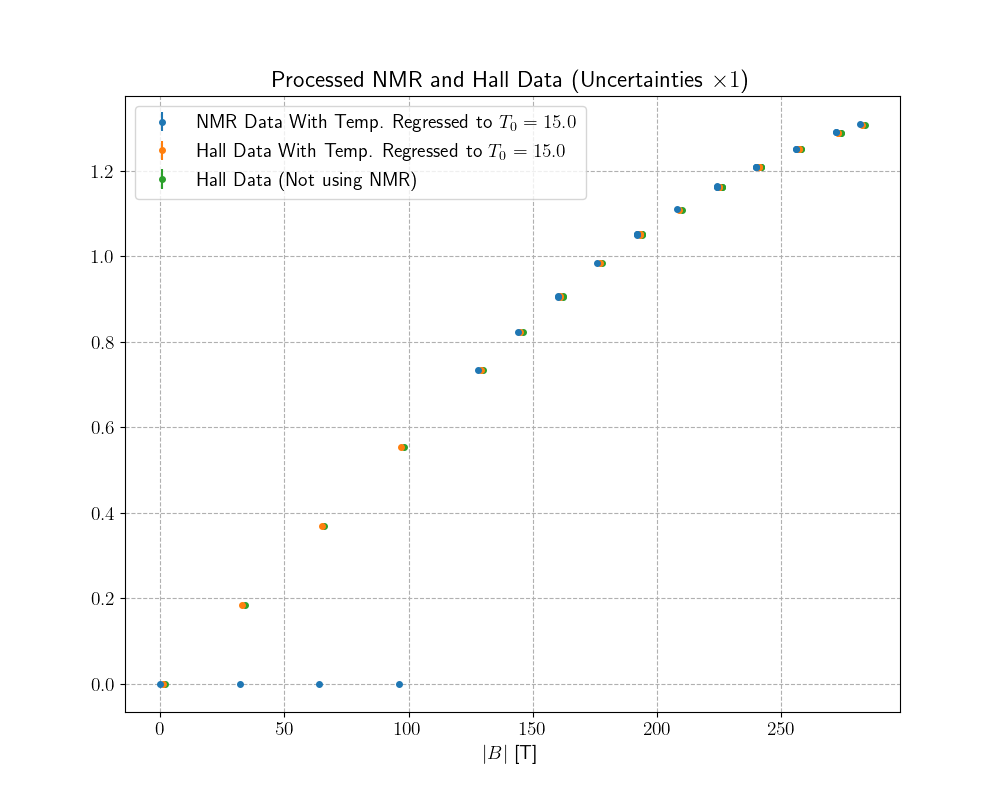

In [22]:
T0 = 15.
fig, ax = plt.subplots()
I = df_info.I.values
NMR_tuples = [get_NMR(T0, i) for i in df_info.index]
NMRs = np.array([i[0] for i in NMR_tuples])
NMR_errs = np.array([i[1] for i in NMR_tuples])
Hall_tuples = [get_Hall(T0, i) for i in df_info.index]
Halls = np.array([i[0] for i in Hall_tuples])
Hall_errs = np.array([i[1] for i in Hall_tuples])
Hall_old_tuples = [get_Hall_old(T0, i) for i in df_info.index]
Hall_olds = np.array([i[0] for i in Hall_old_tuples])
Hall_old_errs = np.array([i[1] for i in Hall_old_tuples])

sf = 1
#sf = 1e4
#sf = 1e3

ax.errorbar(I, NMRs, yerr=sf*NMR_errs, fmt='o', ls='none', ms=4, zorder=100,
            label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
ax.errorbar(I+1, Halls, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, zorder=99,
            label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')
ax.errorbar(I+2, Hall_olds, yerr=sf*Hall_old_errs, fmt='o', ls='none', ms=4, zorder=98,
            label=rf'Hall Data (Not using NMR)')
#ax.errorbar(I+1, Halls-Hall_olds, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, zorder=99,
#             label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')


#ax.set_ylim([-0.5, 2])
#ax.set_ylim([-0.1, 1.5])

ax.set_xlabel('Magnet Current [A]')
ax.set_xlabel(r'$|B|$ [T]')
ax.set_title(rf'Processed NMR and Hall Data (Uncertainties $\times {int(sf):0d}$)')
ax.legend().set_zorder(101);

<IPython.core.display.Javascript object>


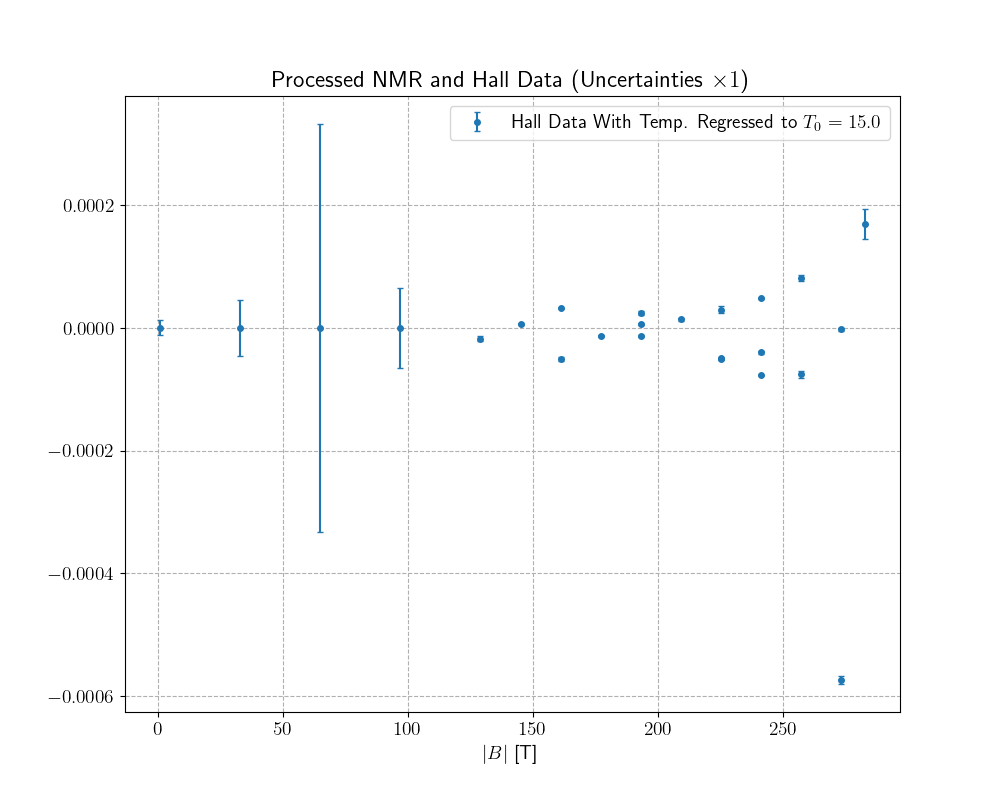

In [24]:
fig, ax = plt.subplots()

sf = 1
#sf = 1e4
#sf = 1e3

# ax.errorbar(I, NMRs, yerr=sf*NMR_errs, fmt='o', ls='none', ms=4, zorder=100,
#             label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
# ax.errorbar(I+1, Halls, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, zorder=99,
#             label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')
# ax.errorbar(I+2, Hall_olds, yerr=sf*Hall_old_errs, fmt='o', ls='none', ms=4, zorder=98,
#             label=rf'Hall Data (Not using NMR)')
ax.errorbar(I+1, Halls-Hall_olds, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, zorder=99,
             label=rf'Hall Data With Temp. Regressed to $T_0={T0}$',
               capsize=2)


#ax.set_ylim([-0.5, 2])
#ax.set_ylim([-0.1, 1.5])

ax.set_xlabel('Magnet Current [A]')
ax.set_xlabel(r'$|B|$ [T]')
ax.set_title(rf'Processed NMR and Hall Data (Uncertainties $\times {int(sf):0d}$)')
ax.legend().set_zorder(101);

In [23]:
Hall_errs

array([8.86540624e-07, 9.75115992e-07, 6.80371572e-07, 1.20676694e-05,
       4.54576188e-05, 3.32272461e-04, 6.55705988e-05, 4.26531634e-06,
       1.71777737e-06, 3.59174957e-06, 1.19068864e-06, 3.09712143e-06,
       1.76032687e-06, 1.76847482e-06, 5.85939721e-06, 2.31565491e-06,
       5.59440216e-06, 2.45397583e-06, 2.37617948e-05, 6.79084509e-06,
       4.66444498e-06, 8.90309480e-07, 1.41318768e-06, 1.83026549e-07])

In [85]:
I

array([2.40069467e+02, 2.24065923e+02, 2.40069009e+02, 8.50279556e-04,
       3.20110056e+01, 6.40217106e+01, 9.60287455e+01, 1.28038948e+02,
       1.44044132e+02, 1.60047885e+02, 1.76051258e+02, 1.92056063e+02,
       1.92056237e+02, 2.08060745e+02, 2.24065366e+02, 2.40068824e+02,
       2.56071131e+02, 2.72075589e+02, 2.81677455e+02, 2.72075324e+02,
       2.56070678e+02, 2.24064884e+02, 1.92055609e+02, 1.60047416e+02])

In [76]:
Halls

array([1.20820851e+00, 1.16319913e+00, 1.20789778e+00, 9.03266818e-04,
       1.84313565e-01, 3.69930982e-01, 5.53525332e-01, 7.33965311e-01,
       8.22365377e-01, 9.06590698e-01, 9.83805736e-01, 1.05116440e+00,
       1.05023854e+00, 1.10946241e+00, 1.16146119e+00, 1.20849013e+00,
       1.25097547e+00, 1.28864678e+00, 1.30810386e+00, 1.28859869e+00,
       1.25107489e+00, 1.16154432e+00, 1.05111456e+00, 9.05913614e-01])

In [77]:
Hall_errs

array([8.86540624e-07, 9.75115992e-07, 6.80371572e-07, 1.20676694e-05,
       4.54576188e-05, 3.32272461e-04, 6.55705988e-05, 4.26531634e-06,
       1.71777737e-06, 3.59174957e-06, 1.19068864e-06, 3.09712143e-06,
       1.76032687e-06, 1.76847482e-06, 5.85939721e-06, 2.31565491e-06,
       5.59440216e-06, 2.45397583e-06, 2.37617948e-05, 6.79084509e-06,
       4.66444498e-06, 8.90309480e-07, 1.41318768e-06, 1.83026549e-07])

In [ ]:
# NMR

In [48]:
def get_T0_func(results):
    # results can be a dictionary from either NMR or Hall temperature regression
    def lin_plus_unc(T0, run_num):
        x = T0 # redefinition
        # model calculation at T0
        y0 = mod_lin(x, **results[run_num].params)
        # error propagation
        cov = results[run_num].covar
        yerr = (x**2 * cov[1,1] + cov[0,0] + 2 * x * cov[0,1])**(1/2)
        return y0, yerr
    return lin_plus_unc

In [49]:
get_NMR = get_T0_func(results_nmr)

In [50]:
# example for looking at hysteresis
get_NMR(15, 0), get_NMR(15, 2)

((1.2089363059212448, 2.7595765939920406e-07),
 (1.2086169146919337, 4.770863649341329e-07))

In [51]:
# water chiller out
get_NMR(15, 11), get_NMR(15, 12)

((1.0513718723676746, 1.0100941690920784e-06),
 (1.0504595525603153, 6.09440293307569e-07))

In [52]:
df_info.columns

Index(['t0', 'tf', 'ramp', 'hyst', 'adc', 'chiller', 'NMR', 'B_NMR', 'I',
       'hours_data', 'num_meas'],
      dtype='object')

In [53]:
df_info.I

0     240.069467
1     224.065923
2     240.069009
3       0.000850
4      32.011006
5      64.021711
6      96.028746
7     128.038948
8     144.044132
9     160.047885
10    176.051258
11    192.056063
12    192.056237
13    208.060745
14    224.065366
15    240.068824
16    256.071131
17    272.075589
18    281.677455
19    272.075324
20    256.070678
21    224.064884
22    192.055609
23    160.047416
Name: I, dtype: float64

<IPython.core.display.Javascript object>


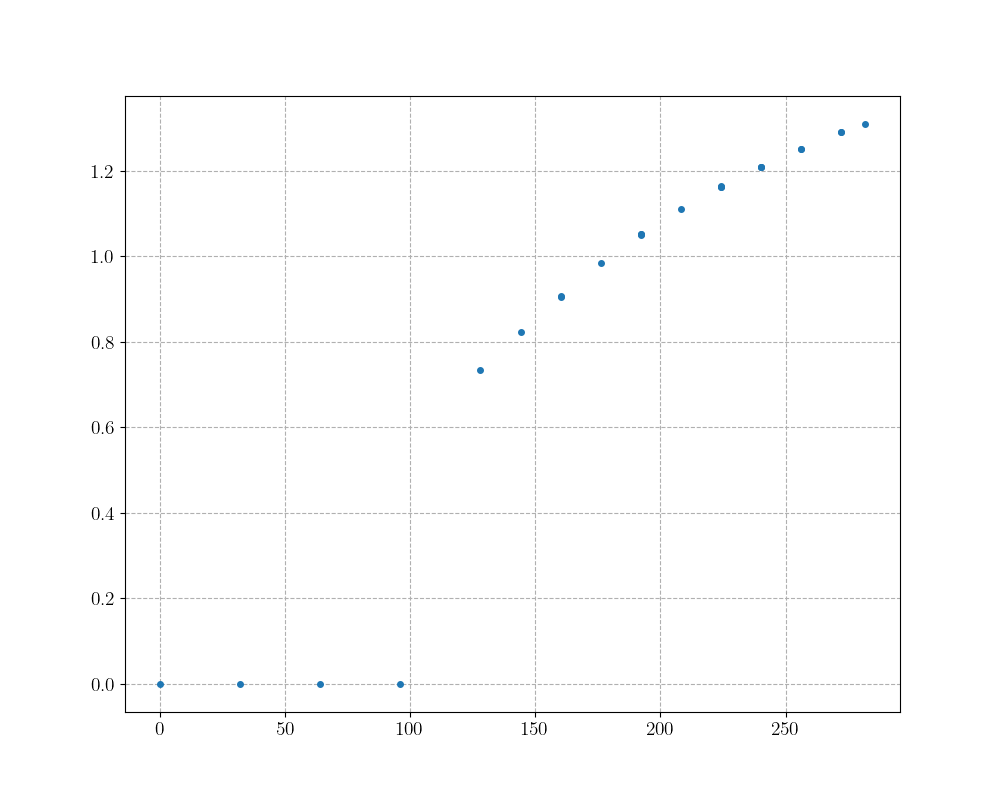

NameError: name 'Halls' is not defined

In [74]:
T0 = 15.
fig, ax = plt.subplots()
I = df_info.I.values
NMR_tuples = [get_NMR(T0, i) for i in df_info.index]
NMRs = np.array([i[0] for i in NMR_tuples])
NMR_errs = np.array([i[1] for i in NMR_tuples])

ax.errorbar(I, NMRs, yerr=NMR_errs, fmt='o', ls='none', ms=4, label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
ax.errorbar(I, Halls, yerr=Hall_errs, fmt='o', ls='none', ms=4, label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')

ax.set_xlabel('Magnet Current [A]')
ax.set_xlabel(r'$|B|$ [T]')
ax.legend();

In [55]:
I, NMRs, NMR_errs

(array([2.40069467e+02, 2.24065923e+02, 2.40069009e+02, 8.50279556e-04,
        3.20110056e+01, 6.40217106e+01, 9.60287455e+01, 1.28038948e+02,
        1.44044132e+02, 1.60047885e+02, 1.76051258e+02, 1.92056063e+02,
        1.92056237e+02, 2.08060745e+02, 2.24065366e+02, 2.40068824e+02,
        2.56071131e+02, 2.72075589e+02, 2.81677455e+02, 2.72075324e+02,
        2.56070678e+02, 2.24064884e+02, 1.92055609e+02, 1.60047416e+02]),
 array([1.20893631, 1.16365581, 1.20861691, 0.        , 0.        ,
        0.        , 0.        , 0.73399042, 0.82241001, 0.90666506,
        0.98392582, 1.05137187, 1.05045955, 1.10983424, 1.16199637,
        1.20922925, 1.25193369, 1.28984014, 1.30942059, 1.28977017,
        1.25201054, 1.16205604, 1.05135218, 0.90600039]),
 array([2.75957659e-07, 5.02631886e-07, 4.77086365e-07, 4.02255610e-07,
        1.51506173e-06, 1.10691823e-05, 2.18561415e-06, 3.74491282e-06,
        1.30349962e-06, 2.92804858e-06, 4.69904383e-07, 1.01009417e-06,
        6.09440293e-

In [56]:
df

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,C90000000D53983A_Cal_Theta,C90000000D53983A_Cal_Phi,C50000000D5E473A_Cal_Bmag,C50000000D5E473A_Raw_Bmag,C50000000D5E473A_Cal_Theta,C50000000D5E473A_Cal_Phi,6A0000000D61333A_Cal_Bmag,6A0000000D61333A_Raw_Bmag,6A0000000D61333A_Cal_Theta,6A0000000D61333A_Cal_Phi
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-02-24 13:28:38,2/24/2021 1:28:38 PM,240.069750,28.571600,29.840097,28.007162,7.107207,10.018359,10.879767,13.184784,15.563291,...,0.634256,0.461928,0.019541,52820.278000,0.393066,-1.810713,1.208088,3.339608e+06,1.533355,-0.029645
2021-02-24 13:29:38,2/24/2021 1:29:38 PM,240.069580,28.571800,29.787987,28.031197,7.115325,10.044732,10.914607,13.178277,15.564605,...,0.639018,0.478226,0.019563,52879.389747,0.392020,-1.813439,1.208077,3.339573e+06,1.533372,-0.029659
2021-02-24 13:30:38,2/24/2021 1:30:38 PM,240.069580,28.571950,29.807564,28.020391,7.117673,10.037371,10.909006,13.181531,15.567900,...,0.643944,0.480042,0.019545,52832.497244,0.391607,-1.818623,1.208095,3.339627e+06,1.533381,-0.029671
2021-02-24 13:31:39,2/24/2021 1:31:39 PM,240.069580,28.572000,29.803446,28.041353,7.122602,10.033122,10.869917,13.189683,15.573018,...,0.654508,0.476417,0.019564,52881.807231,0.391571,-1.812446,1.208056,3.339513e+06,1.533380,-0.029650
2021-02-24 13:32:37,2/24/2021 1:32:37 PM,240.069693,28.572150,29.791532,28.036276,7.136472,10.048101,10.879786,13.194210,15.577725,...,0.645205,0.429792,0.019524,52774.291326,0.391391,-1.813996,1.208060,3.339515e+06,1.533353,-0.029667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05 08:05:03,4/5/2021 8:05:03 AM,160.047520,18.885693,26.896858,26.822971,16.732733,18.459539,18.649643,21.047083,18.768127,...,0.970517,2.888543,0.015893,42950.653429,0.317596,-1.829484,0.905717,2.480947e+06,1.533656,-0.029834
2021-04-05 08:06:03,4/5/2021 8:06:03 AM,160.047463,18.885840,26.895796,26.856619,16.735105,18.453161,18.628620,21.054861,18.767283,...,0.943318,2.915374,0.015821,42758.225197,0.315563,-1.832642,0.905659,2.480789e+06,1.533654,-0.029908
2021-04-05 08:07:03,4/5/2021 8:07:03 AM,160.047520,18.885925,26.894203,26.892708,16.730320,18.454494,18.626814,21.064997,18.768127,...,0.958443,2.944741,0.015898,42965.195531,0.317445,-1.835288,0.905706,2.480906e+06,1.533670,-0.029860


In [57]:
param_Bs = np.array([result.params['B'].value for key, result in sorted(results_nmr.items())])
param_Bs

array([-9.93390540e-05, -1.00993925e-04, -9.03672879e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.56952279e-06,
       -8.69016253e-06, -2.57869405e-05, -4.03838452e-05, -5.48514543e-05,
       -6.32980515e-05, -7.87149645e-05, -8.57058010e-05, -1.02071814e-04,
       -1.18368166e-04, -1.49660849e-04, -1.13862048e-04, -1.47258860e-04,
       -1.41849063e-04, -1.20681798e-04, -9.76612417e-05, -5.47877745e-05])

In [64]:
param_Berrs = np.array([result.params['B'].stderr for key, result in sorted(results_nmr.items())])
param_Berrs

array([1.55691992e-07, 4.14887879e-07, 2.35315686e-07, 2.19012343e-07,
       5.12622602e-07, 3.86023332e-06, 8.83427694e-07, 1.88667595e-06,
       8.44107262e-07, 2.48428732e-06, 6.97753797e-07, 3.29157412e-06,
       2.19616845e-07, 3.23579857e-07, 1.08303627e-06, 3.24740029e-07,
       7.15860969e-07, 2.41918064e-07, 2.41234991e-06, 7.17906710e-07,
       5.26767030e-07, 1.21888091e-07, 1.98844662e-07, 1.37909429e-08])

In [58]:
param_Bs / NMRs

<ipython-input-58-77fe00a7309c>:1: RuntimeWarning: invalid value encountered in true_divide
  param_Bs / NMRs


array([-8.21706268e-05, -8.67902041e-05, -7.47691736e-05,             nan,
                   nan,             nan,             nan, -1.16752516e-05,
       -1.05667032e-05, -2.84415290e-05, -4.10435874e-05, -5.21713161e-05,
       -6.02574858e-05, -7.09249740e-05, -7.37573745e-05, -8.44106390e-05,
       -9.45482713e-05, -1.16030541e-04, -8.69560542e-05, -1.14174497e-04,
       -1.13297021e-04, -1.03851961e-04, -9.28910824e-05, -6.04721311e-05])

<IPython.core.display.Javascript object>


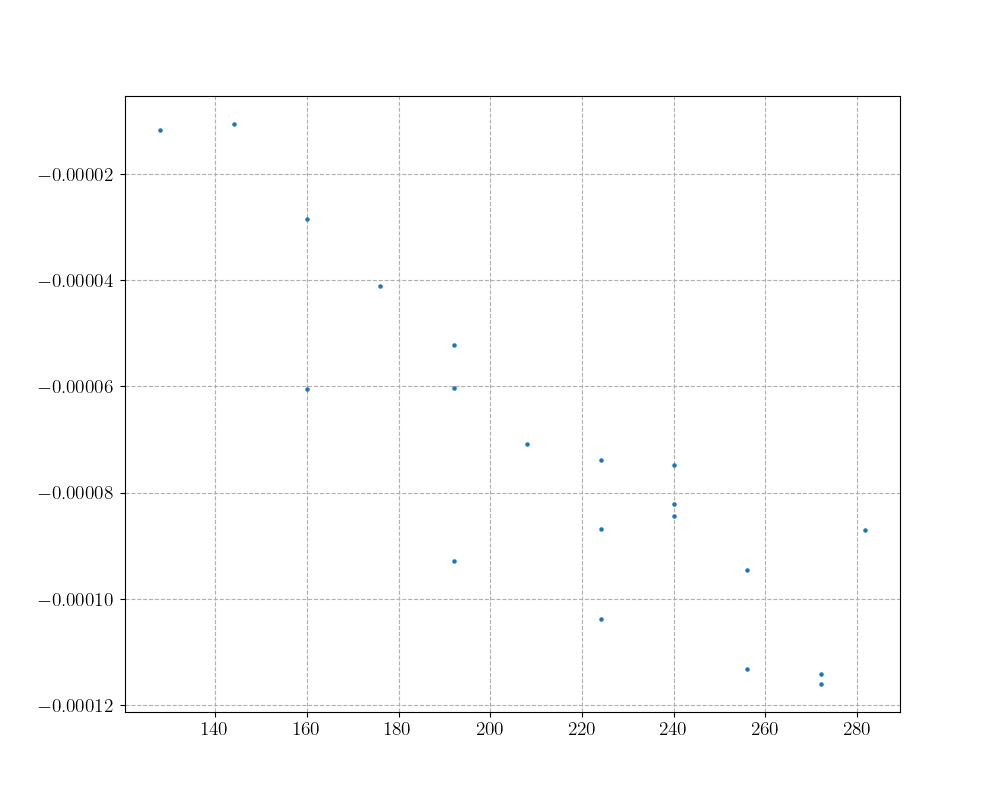

<ipython-input-59-55d4bd3a70d2>:2: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(I, param_Bs/NMRs, s=5)


In [59]:
fig, ax = plt.subplots()
ax.scatter(I, param_Bs/NMRs, s=5)

In [60]:
df_info.ramp.values

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False])

In [63]:
param_Bs

array([-9.93390540e-05, -1.00993925e-04, -9.03672879e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.56952279e-06,
       -8.69016253e-06, -2.57869405e-05, -4.03838452e-05, -5.48514543e-05,
       -6.32980515e-05, -7.87149645e-05, -8.57058010e-05, -1.02071814e-04,
       -1.18368166e-04, -1.49660849e-04, -1.13862048e-04, -1.47258860e-04,
       -1.41849063e-04, -1.20681798e-04, -9.76612417e-05, -5.47877745e-05])

<IPython.core.display.Javascript object>


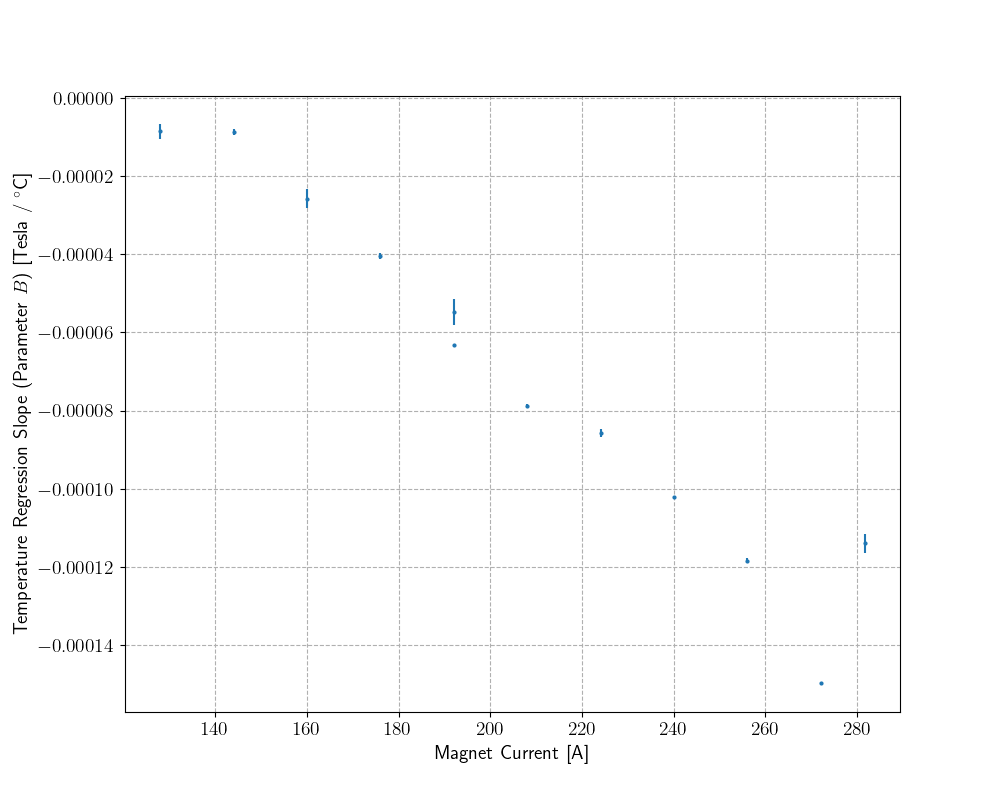

Text(0, 0.5, 'Temperature Regression Slope (Parameter $B$) [Tesla / $^\\circ$C]')

In [67]:
# MAKE NICE VERSION
m = (df_info.ramp.values) & (df_info.NMR.values)
fig, ax = plt.subplots()
#ax.scatter(I[m], param_Bs[m], s=10)
ax.errorbar(I[m], param_Bs[m], yerr=param_Berrs[m], fmt='o', ls='none', ms=2, zorder=99)
ax.set_xlabel('Magnet Current [A]')
#ax.set_ylabel(r'$|B|_{\mathrm{Hall}}/|B|_{\mathrm{NMR}}$')
ax.set_ylabel(r'Temperature Regression Slope (Parameter $B$) [Tesla / $^\circ$C]')

# Load Factory Function From Script

In [71]:
from factory_funcs import get_NMR_B_at_T0_func, get_Hall_B_at_T0_func

In [5]:
get_NMR = get_NMR_B_at_T0_func(results_nmr)
get_Hall = get_Hall_B_at_T0_func(results_hall_nmr, results_nmr)

<IPython.core.display.Javascript object>


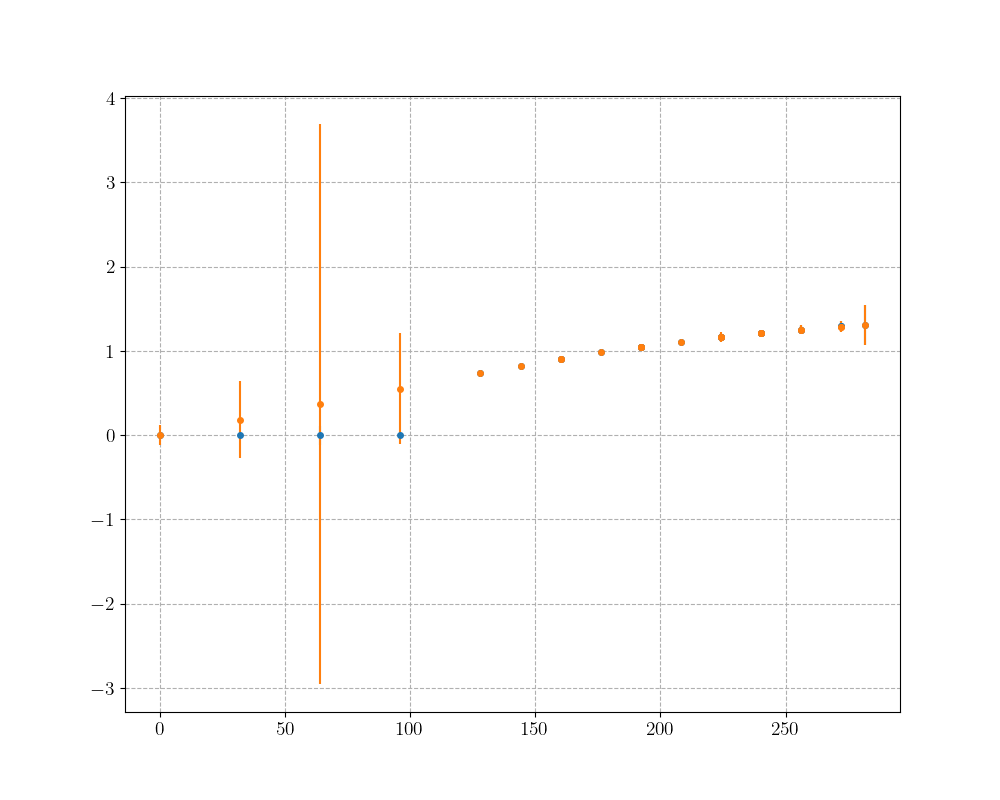

<ErrorbarContainer object of 3 artists>

In [8]:
T0 = 15.
fig, ax = plt.subplots()
I = df_info.I.values
NMR_tuples = [get_NMR(T0, i) for i in df_info.index]
NMRs = np.array([i[0] for i in NMR_tuples])
NMR_errs = np.array([i[1] for i in NMR_tuples])
Hall_tuples = [get_Hall(T0, i) for i in df_info.index]
Halls = np.array([i[0] for i in Hall_tuples])
Hall_errs = np.array([i[1] for i in Hall_tuples])

sf = 1e4
#sf = 1

ax.errorbar(I, NMRs, yerr=sf*NMR_errs, fmt='o', ls='none', ms=4, label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
ax.errorbar(I, Halls, yerr=sf*Hall_errs, fmt='o', ls='none', ms=4, label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')

In [22]:
I_all = df['Magnet Current [A]'].values
ratio_all = df[f'{probe}_Cal_Bmag']/df['NMR [T]'].values

<IPython.core.display.Javascript object>


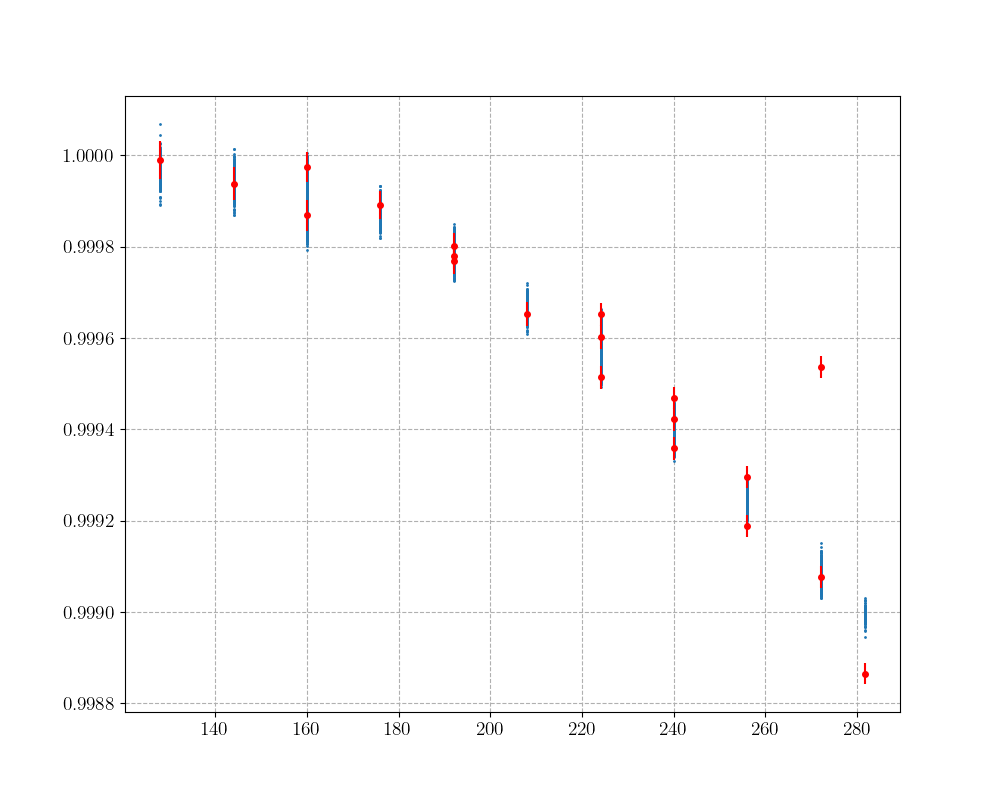

<ipython-input-27-b0d3c0fedd34>:11: RuntimeWarning: divide by zero encountered in true_divide
  Rs = Halls/NMRs
<ipython-input-27-b0d3c0fedd34>:12: RuntimeWarning: divide by zero encountered in true_divide
  sigma_Rs = Rs * ((3e-5/Halls)**2 + (1e-6/NMRs)**2)**(1/2)


<ErrorbarContainer object of 3 artists>

In [27]:
T0 = 15.
fig, ax = plt.subplots()
I = df_info.I.values
NMR_tuples = [get_NMR(T0, i) for i in df_info.index]
NMRs = np.array([i[0] for i in NMR_tuples])
NMR_errs = np.array([i[1] for i in NMR_tuples])
Hall_tuples = [get_Hall(T0, i) for i in df_info.index]
Halls = np.array([i[0] for i in Hall_tuples])
Hall_errs = np.array([i[1] for i in Hall_tuples])

Rs = Halls/NMRs
sigma_Rs = Rs * ((3e-5/Halls)**2 + (1e-6/NMRs)**2)**(1/2)

ax.scatter(I_all, ratio_all, s=1, zorder=99)
##ax.scatter(I, Halls/NMRs, zorder=100)
ax.errorbar(I, Rs, yerr=sigma_Rs, fmt='o', color='red', ls='none', ms=4,
            label=rf'Hall/NMR Data With Temp. Regressed to $T_0={T0}$', zorder=100)
#ax.errorbar(I, NMRs, yerr=NMR_errs, fmt='o', ls='none', ms=4, label=rf'NMR Data With Temp. Regressed to $T_0={T0}$')
#ax.errorbar(I, Halls, yerr=Hall_errs, fmt='o', ls='none', ms=4, label=rf'Hall Data With Temp. Regressed to $T_0={T0}$')